## RandomForest

In [18]:
import sklearn.datasets
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from sklearn.metrics import r2_score
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import cross_val_score
from sklearn.tree import plot_tree
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import RandomizedSearchCV

In [3]:
data=sklearn.datasets.fetch_california_housing()
feature=data.data
target=data.target

In [4]:
x_train, x_test, y_train, y_test = train_test_split(feature, target, train_size=0.7, shuffle=True, random_state=0)

In [5]:
df_train=pd.DataFrame(x_train, columns=data.feature_names)
df_train['target']=y_train
df_test=pd.DataFrame(x_test, columns=data.feature_names)
df_test['target']=y_test

### ランダムフォレストで回帰（グリッドサーチなし）

In [6]:
rfr=RandomForestRegressor(random_state=1)
rfr.fit(x_train, y_train)

RandomForestRegressor(random_state=1)

In [7]:
test_pred=rfr.predict(x_test)

In [8]:
print('RMSE_Test_notpara', mean_squared_error(y_test, test_pred, squared=False))

RMSE_Test_notpara 0.5247389266794545


グリッドサーチなし状態でもRMSEは結構高い

### ランダムフォレスト（グリッドサーチによるハイパラ探索）  
https://di-acc2.com/programming/python/8465/  
parameters = {  
    'n_estimators': [10, 20, 30, 50, 100, 300],     # 用意する決定木モデルの数  
    'max_features': ('sqrt', 'log2','auto', None),  # ランダムに指定する特徴量の数  
    'max_depth':    (10, 20, 30, 40, 50, None),     # 決定木のノード深さの制限値  
}

In [9]:
param={'n_estimators':[100, 150],
       'max_features': ('log2', None),  #'auto'はいらない
       'max_depth':    (50, None)}

grid_search=GridSearchCV(RandomForestRegressor(random_state=1), param_grid=param, cv=5)
grid_search.fit(x_train, y_train)

GridSearchCV(cv=5, estimator=RandomForestRegressor(random_state=1),
             param_grid={'max_depth': (50, None),
                         'max_features': ('log2', None),
                         'n_estimators': [100, 150]})

In [10]:
grid_search.best_params_

{'max_depth': 50, 'max_features': 'log2', 'n_estimators': 150}

現状これがベスト
{'max_depth': 50, 'max_features': 'log2', 'n_estimators': 150}


In [17]:
pred_test_grid=grid_search.predict(x_test)
print('RMSE_Test_para', mean_squared_error(y_test, pred_test_grid, squared=False))

RMSE_Test_para 0.4943376233182124


#### グリッドサーチが長いのでランダムサーチで探索してみる  
https://free.kikagaku.ai/tutorial/basic_of_machine_learning/learn/machine_learning_hyperparameters  
https://ailog.site/2022/01/12/2022/0112/

In [56]:
#評価指標はRMSE
scoring = 'neg_root_mean_squared_error'
#探索するパラメータをここで辞書型で定義しておく
#こいつは長い
param2={'n_estimators':[150, 160, 170, 180, 190],
       'max_features': ('log2', None),  #'auto'はいらない
       'max_depth':    (50, None)}
#こいつはそこそこ長い
param3={'n_estimators':[150, 160, 170, 180, 190]}

param4={'n_estimators':[190,200]}

In [55]:
rscv=RandomizedSearchCV(RandomForestRegressor(max_features='log2', max_depth=50, random_state=1), 
                        param_distributions=param4, cv=5, scoring=scoring,
                        n_iter=2, random_state=1)
rscv.fit(x_train, y_train)

RandomizedSearchCV(cv=5,
                   estimator=RandomForestRegressor(max_depth=50,
                                                   max_features='log2',
                                                   random_state=1),
                   n_iter=2, param_distributions={'n_estimators': [190, 200]},
                   random_state=1, scoring='neg_root_mean_squared_error')

In [57]:
rscv.best_params_

{'n_estimators': 190}

'n_estimators': 190がだいたい最適の可能性が高い

In [58]:
rscv.best_score_

-0.4953312603280091

In [59]:
#ランダムサーチで求めたハイパーパラメータで学習、testデータを予測
rfr_randomsearch=rscv.best_estimator_.fit(x_train, y_train)
test_pred_ramdom=rfr_randomsearch.predict(x_test)

In [60]:
print('RMSE_Test_randomsearch', mean_squared_error(y_test, test_pred_ramdom, squared=False))

RMSE_Test_randomsearch 0.4943454487059083


### 特徴量重要度を算出(グリッドサーチ)

In [47]:
#best_estimator_に改めてtrainをfit
rfr_gridsearch=grid_search.best_estimator_.fit(x_train, y_train)

In [48]:
rfr_best.feature_importances_

array([0.39372189, 0.05423957, 0.10675807, 0.03875188, 0.03059975,
       0.12277775, 0.12952607, 0.12362503])

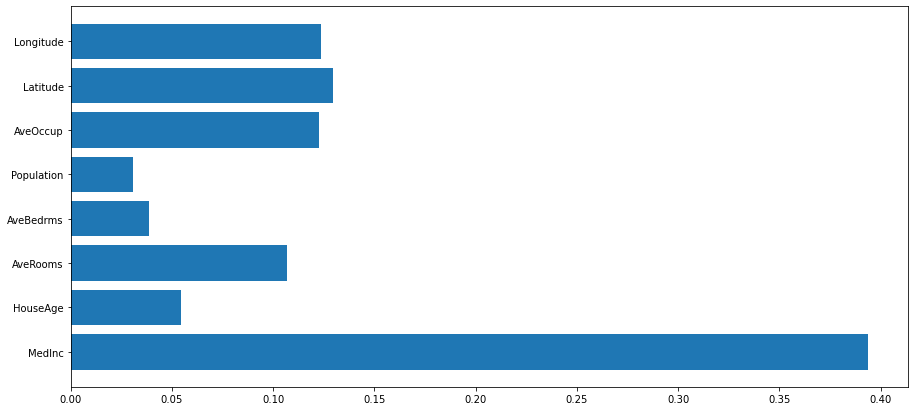

In [49]:
plt.figure(figsize=(15,7))
plt.barh(range(8), rfr_best.feature_importances_, tick_label=df_train.loc[:,'MedInc':'Longitude'].columns)
plt.show()